In [1]:
# imports
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import cycle
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
pd.set_option('max_rows',1000)
import os
import math
from matplotlib.backends.backend_pdf import PdfPages
import scipy
from scipy import stats
import subprocess

prefix = "/Volumes/users/Corinne_Simonti/projects/RNA/"

In [43]:
# Making comparisons
out_list = []

fn = prefix + "data/ct/file_list.txt"

for line in open(fn):
    out_list.append(line.rstrip('\n'))

# Dictionaries and lists.
gs2len = {}
gs_index2prop = {}

GENE_LIST = []
STRAIN_LIST = ["N2", "Hawaii"]

# Parse files.
for fn in out_list:
    part = fn.split('/')
    g1 = part[-1].split('.')
    if len(g1) > 2:
        g2 = ('.').join(g1[0:-1])
    else:
        g2 = g1[0]
    GENE = g2.split("_")[0]
    if GENE not in GENE_LIST:
        GENE_LIST.append(GENE)
    STRAIN = g2.split("_")[1]
    for line in open(fn):
        seg = line.split()
        if len(seg) == 2:
            PAIR_LIST = []
            LENGTH = int(seg[-2])
            ID = seg[-1].rstrip('\n')
            if (GENE,STRAIN) in gs2len:
                continue
            gs2len[(GENE,STRAIN)] = LENGTH
        else:
            INDEX = int(seg[-1])
            if (GENE,STRAIN,INDEX) not in gs_index2prop:
                gs_index2prop[(GENE,STRAIN,INDEX)] = 0
            MATCH = int(seg[-2])
            if MATCH == 0:
                continue
            gs_index2prop[(GENE,STRAIN,INDEX)] += 1

        
gs_index2prop[(GENE,STRAIN,INDEX)]

44

In [42]:
# Parsing profiler outfiles.
fn = prefix + "results/structures/file_list.txt"

for line in open(fn):
    out_list.append(line.rstrip('\n'))
    
# Dictionaries and lists.
gs2seq = {}
gs2hel = {}
gs_hel2freq = {}

# Get helix class information.
for fn in out_list:
    part = fn.split('/')
    g1 = part[-1].split('.')
    if len(g1) > 2:
        g2 = ('.').join(g1[0:-1])
    else:
        g2 = g1[0]
    GENE = g2.split("_")[0]
    if GENE not in GENE_LIST:
        GENE_LIST.append(GENE)
    STRAIN = g2.split("_")[1]
    helix2loc = {}
    if (GENE,STRAIN) not in gs2hel:
        gs2hel[(GENE,STRAIN)] = []
    for line in open(fn):
        seg = line.split(' ')
        if seg[0] == "seq":
            SEQ = seg[-4]
            gs2seq[(GENE,STRAIN)] = SEQ
            LENGTH = int(seg[-1])
            gs2len[(GENE,STRAIN)] = LENGTH
        if seg[0] == "Helix":
            HELIX = str(seg[1])
            START = int(seg[3])
            END = int(seg[4])
            LENGTH = int(seg[5])
            FREQ = int(seg[-1])
            helix2loc[HELIX] = [START,END,LENGTH]
        if seg[0] == "Featured":
            HELIX = str(seg[2].rstrip(':'))
            START = int(seg[3])
            END = int(seg[4])
            LENGTH = int(seg[5])
            FREQ = int(seg[-1])
            H = (START,END,LENGTH)
            if H not in gs2hel[(GENE,STRAIN)]:
                gs2hel[(GENE,STRAIN)].append(H)
            gs_hel2freq[(GENE,STRAIN,H)] = FREQ
        if seg[0] == "Profile":
            FREQ = int(seg[-2])
            HLIST = seg[1:-4]
            if len(HLIST) == 1:
                if HLIST[0] == '':
                    continue
            for H in HLIST:
                if H == '':
                    continue
                if H not in helix2loc:
                    print(GENE,STRAIN,H)
                START = int(helix2loc[H][0])
                END = int(helix2loc[H][1])
                LENGTH = int(helix2loc[H][2])
        if seg[0] == "Selected":
            FREQ = int(seg[-2])
            HLIST = seg[2:-4]
            if len(HLIST) == 1:
                if HLIST[0] == '':
                    continue
            for H in HLIST:
                #if H not in helix2loc:
                    #print(GENE,STRAIN,H)
                START = int(helix2loc[H][0])
                END = int(helix2loc[H][1])
                LENGTH = int(helix2loc[H][2])



In [53]:
GENE = "rad-50"

Nseq = gs2seq[(GENE, "N2")]
Hseq = gs2seq[(GENE, "Hawaii")]

# 1 indexed.
i = 0
while i < len(Nseq):
    if Nseq[i] == Hseq[i]:
        i += 1
        continue
    print(i+1,Nseq[i],Hseq[i])
    i += 1


80 U C
84 C U


In [54]:
gshdict = {}
gshdict['gene'] = []
gshdict['helix'] = []
gshdict['Nfrq'] = []
gshdict['Hfrq'] = []

for G in GENE_LIST:
    for H in gs2hel[(G,"N2")]:
        gshdict['gene'].append(G)
        gshdict['helix'].append(H)
        gshdict['Nfrq'].append(gs_hel2freq[(G,"N2",H)])
        if H in gs2hel[(G,"Hawaii")]:
            gshdict['Hfrq'].append(gs_hel2freq[(G,"Hawaii",H)])
        else:
            gshdict['Hfrq'].append(0)
    for H in gs2hel[(G,"Hawaii")]:
        if H in gshdict['helix']:
            continue
        gshdict['gene'].append(G)
        gshdict['helix'].append(H)
        gshdict['Hfrq'].append(gs_hel2freq[(G,"Hawaii",H)])
        gshdict['Nfrq'].append(0)
    
    
gsh = pd.DataFrame.from_dict(gshdict, orient='columns')

gsh['diff'] = abs(gsh['Nfrq'] - gsh['Hfrq'])

gsh.loc[gsh["gene"] == GENE, :].sort_values("diff", ascending=False)

,gene,helix,Nfrq,Hfrq,diff
22,rad-50,"(47, 88, 6)",0,677,677
13,rad-50,"(45, 104, 3)",909,238,671
24,rad-50,"(42, 95, 5)",0,670,670
23,rad-50,"(53, 81, 3)",0,670,670
14,rad-50,"(53, 96, 5)",868,215,653
17,rad-50,"(42, 109, 2)",517,0,517
25,rad-50,"(58, 76, 2)",0,488,488
18,rad-50,"(69, 81, 3)",432,0,432
19,rad-50,"(62, 88, 2)",392,0,392
26,rad-50,"(102, 108, 2)",0,381,381


In [55]:
g_index2diff = {}

for gene in GENE_LIST:
    for (gene, strain, i) in gs_index2prop:
        if (gene,i) in g_index2diff:
            continue
        g_index2diff[(gene,i)] = gs_index2prop[(gene, "Hawaii", i)] - gs_index2prop[(gene, "N2", i)]
        
diffdict = {}
diffdict['gene'] = []
diffdict['index'] = []
diffdict['difference'] = []

for (G,I) in g_index2diff:
    diffdict['gene'].append(G)
    diffdict['index'].append(I)
    diffdict['difference'].append(g_index2diff[(G,I)])

diff = pd.DataFrame.from_dict(diffdict, orient='columns')

diff.loc[diff["gene"] == GENE, :]

,gene,index,difference
29,rad-50,1,-1
30,rad-50,2,-2
31,rad-50,3,21
32,rad-50,4,7
33,rad-50,5,7
34,rad-50,6,2
35,rad-50,7,7
36,rad-50,8,-1
37,rad-50,9,1
38,rad-50,10,3


In [18]:
STRAIN_LIST

['N2', 'Hawaii']

In [10]:
gsipdict = {}
gsipdict['gene'] = []
gsipdict['strain'] = []
gsipdict['index'] = []
gsipdict['frequency'] = []

for (G,S,I) in gs_index2prop:
    gsipdict['gene'].append(G)
    gsipdict['strain'].append(S)
    gsipdict['index'].append(I)
    gsipdict['frequency'].append(gs_index2prop[(G,S,I)])

gsip = pd.DataFrame.from_dict(gsipdict, orient='columns')

gsip

,gene,strain,index,frequency
0,msp-63,N2,1,0
1,msp-63,N2,2,0
2,msp-63,N2,3,0
3,msp-63,N2,4,7
4,msp-63,N2,5,6
...,...,...,...,...
1765,srp-1,Hawaii,137,72
1766,srp-1,Hawaii,138,106
1767,srp-1,Hawaii,139,69
1768,srp-1,Hawaii,140,48


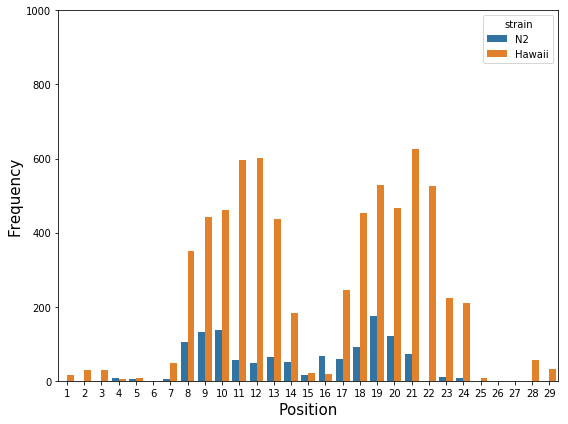

In [11]:
msp63 = gsip.loc[gsip["gene"] == "msp-63",:]

f=plt.figure(figsize=(8,6))

sns.barplot(y='frequency', x='index', data=msp63, hue="strain")

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Position",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

#plt.axvline(x=18, color="black")
#plt.axvline(x=21, color="black")

plt.ylim([0,1000])
#plt.xlim([0,1000])

#plt.legend(loc=2)

plt.tight_layout()

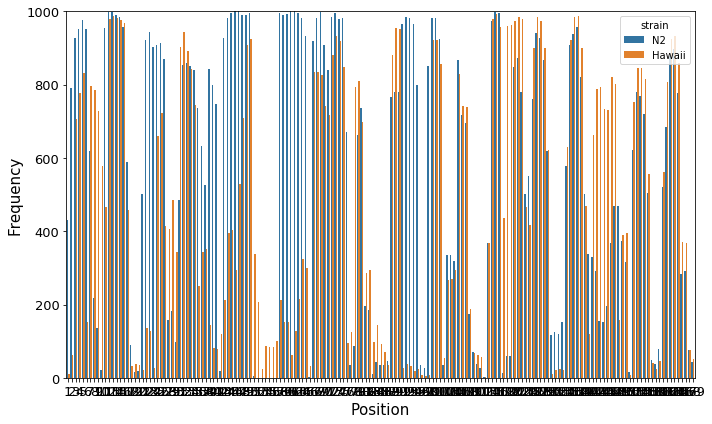

In [17]:
math18 = gsip.loc[gsip["gene"] == "math-18",:]

f=plt.figure(figsize=(10,6))

sns.barplot(y='frequency', x='index', data=math18, hue="strain")

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Position",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

#plt.axvline(x=18, color="black")
#plt.axvline(x=21, color="black")

plt.ylim([0,1000])
#plt.xlim([0,1000])

#plt.legend(loc=2)

plt.tight_layout()

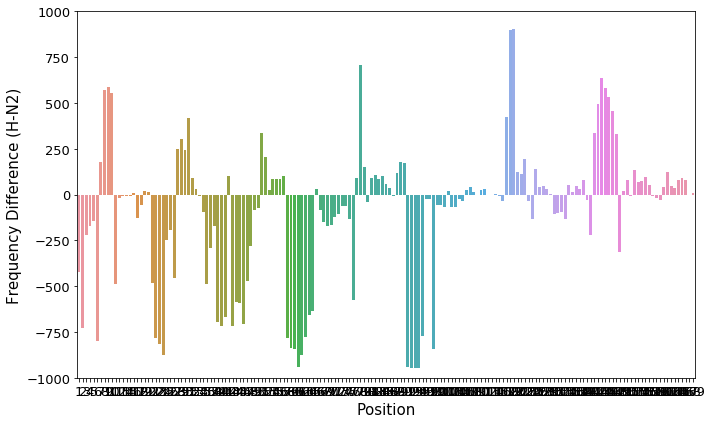

In [18]:
math18 = diff.loc[diff["gene"] == "math-18",:]

f=plt.figure(figsize=(10,6))

sns.barplot(y='difference', x='index', data=math18)

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Position",fontsize=15)
plt.ylabel("Frequency Difference (H-N2)",fontsize=15)

#plt.axhline(y=0.8, color="black")

plt.ylim([-1000,1000])
#plt.xlim([0,1000])

#plt.legend(loc=2)

plt.tight_layout()

In [35]:
GENE = "R10E8.1"

Nseq = gs2seq[(GENE, "N2")]
Hseq = gs2seq[(GENE, "Hawaii")]

# 0 indexed.
i = 0
while i < len(Nseq):
    if Nseq[i] == Hseq[i]:
        i += 1
        continue
    print(i,Nseq[i],Hseq[i])
    i += 1


80 A U
98 A U
175 U A
176 C U
195 A G
203 C A
204 C U
208 G U
237 C A


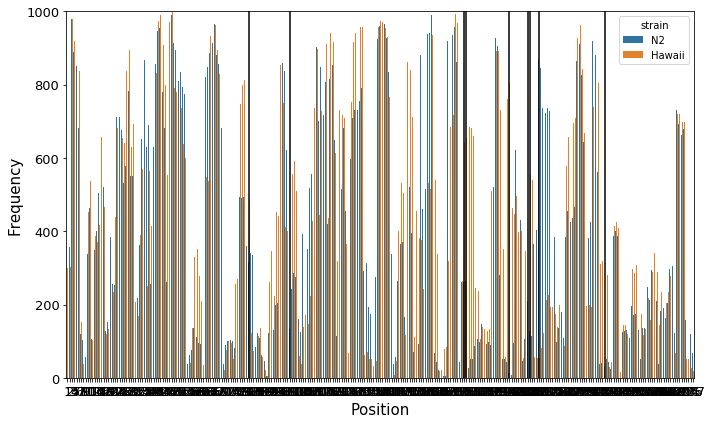

In [25]:
R10E8 = gsip.loc[gsip["gene"] == "R10E8.1",:]

f=plt.figure(figsize=(10,6))

sns.barplot(y='frequency', x='index', data=R10E8, hue="strain")

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Position",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

plt.axvline(x=80, color="black")
plt.axvline(x=98, color="black")
plt.axvline(x=175, color="black")
plt.axvline(x=176, color="black")
plt.axvline(x=195, color="black")
plt.axvline(x=203, color="black")
plt.axvline(x=204, color="black")
plt.axvline(x=208, color="black")
plt.axvline(x=237, color="black")

plt.ylim([0,1000])
#plt.xlim([227,247])

#plt.legend(loc=2)

plt.tight_layout()

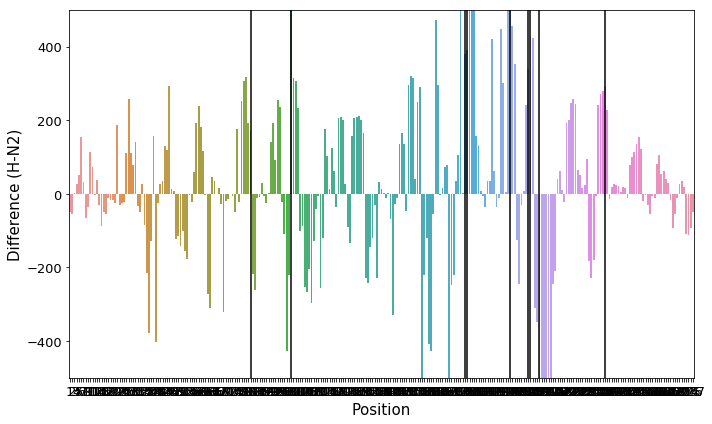

In [26]:
R10E8 = diff.loc[diff["gene"] == "R10E8.1",:]

f=plt.figure(figsize=(10,6))

sns.barplot(y='difference', x='index', data=R10E8)

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Position",fontsize=15)
plt.ylabel("Difference (H-N2)",fontsize=15)

plt.axvline(x=80, color="black")
plt.axvline(x=98, color="black")
plt.axvline(x=175, color="black")
plt.axvline(x=176, color="black")
plt.axvline(x=195, color="black")
plt.axvline(x=203, color="black")
plt.axvline(x=204, color="black")
plt.axvline(x=208, color="black")
plt.axvline(x=237, color="black")

plt.ylim([-500,500])
#plt.xlim([227,247])

#plt.legend(loc=2)

plt.tight_layout()